In [1]:
!pip install torch

In [2]:
from sklearn.datasets import fetch_openml
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
import collections
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.functional as Func
from torch.autograd import Variable
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader, TensorDataset
import random
from scipy.io import savemat
import os 
from os import path
from sklearn.preprocessing import normalize
from torch.nn.utils import clip_grad_norm_
import torch.nn.parallel.data_parallel as data_parallel
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from torch.optim.lr_scheduler import LambdaLR, StepLR, MultiStepLR, ExponentialLR, ReduceLROnPlateau

### Loading the dataset as key value pair

In [3]:
mnist = fetch_openml('mnist_784',version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [4]:
mnist

{'DESCR': "**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  \n**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  \n**Please cite**:  \n\nThe MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered i

In [5]:
import numpy as np
X,y=mnist["data"],mnist["target"]
y=y.astype(int)
X=((X/255.)-.5)*2
print(X.shape,y.shape)
print(min(y),max(y))
print(type(X),type(y))
print(np.min(X), np.max(X))

(70000, 784) (70000,)
0 9
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
-1.0 1.0


### Splittling the data into train and test

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(60000, 784) (10000, 784) (60000,) (10000,)


### Splliting the train data further into train and development/validation

In [7]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state = 42)

for train_index, val_index in split.split(X_train,y_train):
    X_train_strat = X[train_index,:]
    y_train_strat = y[train_index]
    
    X_dev_strat = X[val_index,:]
    y_dev_strat = y[val_index]

print(X_train_strat.shape,y_train_strat.shape,X_dev_strat.shape,y_dev_strat.shape)

(54000, 784) (54000,) (6000, 784) (6000,)


In [8]:
train_images = X_train_strat.reshape(X_train_strat.shape[0], 28, 28) #reshape the images to 54000,28,28 from 54000,784
dev_images = X_dev_strat.reshape(X_dev_strat.shape[0], 28, 28)
test_images = X_test.reshape(X_test.shape[0], 28, 28)

### Converting the data into tensor format for the input to the CNN model

In [9]:
#train
train_images_tensor = torch.tensor(train_images)/255.0
train_labels_tensor = torch.tensor(y_train_strat)
train_tensor = TensorDataset(train_images_tensor, train_labels_tensor)

#dev
dev_images_tensor = torch.tensor(dev_images)/255.0
dev_labels_tensor = torch.tensor(y_dev_strat)
dev_tensor = TensorDataset(dev_images_tensor, dev_labels_tensor)

#test
test_images_tensor = torch.tensor(test_images)/255.0

### Calling Data Loader to save the input tensors 

In [10]:
train_loader = DataLoader(train_tensor, batch_size=16, num_workers=2, shuffle=True)
dev_loader = DataLoader(dev_tensor, batch_size=16, num_workers=2, shuffle=True)
test_loader = DataLoader(test_images_tensor, batch_size=16, num_workers=2, shuffle=False)

### Define hyperparameters

In [11]:

class hyperparam:
    lr = 0.05  # learning rate
    num_epochs = 50  # Number of epochs
    bs = 16  # Mini-batch size +
    moment = 0.9 # Momentum SGD 

### Creating the CNN Architechture with 3 convolution layers and 3 maxpool layers along with activation functions after each convolution and pooling layer. Then passing the output of the convolution block to the fully connected layers with 2 hidden and one output layer.

### **Batch normalization added before each convolution layer**

In [12]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        
        self.linear_block = nn.Sequential(
            #nn.Dropout(p=0.5),
            nn.Linear(128*7*7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            #nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            #nn.Dropout(0.5),
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        
        return x

### Glorat Intialization using xavier normal function in torch

In [13]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.01)

### Call the CNN model and define loss function

In [14]:
cnn_model = CNN()
cnn_model.apply(init_weights) # glorat initialization 
cnn_model.parameters()

<generator object Module.parameters at 0x7f80a9a6a3d0>

### Initializing three things in the next cell:
### 1) Optimizer as Stochastic Gradient Descent with learning rate of 0.05 and momentum of 0.9
### 2) Learning Rate scheduler to adjust the learning rate by 10% every 10 epochs
### 3) Cross Entropy Loss function since its a classification problem

In [15]:
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=hyperparam.lr, momentum=hyperparam.moment)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.CrossEntropyLoss()
if torch.cuda.is_available():
    print('Avaialble')
    cnn_model = cnn_model.cuda()
    criterion = criterion.cuda()

Avaialble


### Training the model and validating side by side to check the results

### Printing the accuracy and loss of train and validation set

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


accuracy 95.74444444444444 98.7
accuracy 98.18333333333334 98.61666666666666
accuracy 98.69814814814815 98.96666666666667
accuracy 98.96111111111111 98.88333333333334
accuracy 99.06296296296296 99.1
accuracy 99.20555555555555 99.26666666666667
accuracy 99.32592592592593 98.88333333333334
accuracy 99.36111111111111 98.9
accuracy 99.50740740740741 99.1
accuracy 99.76481481481481 99.33333333333333
accuracy 99.79444444444445 99.36666666666666
accuracy 99.84814814814816 99.38333333333334
accuracy 99.87407407407407 99.35
accuracy 99.86481481481482 99.38333333333334
accuracy 99.86296296296297 99.35
accuracy 99.9 99.35
accuracy 99.89259259259259 99.36666666666666
accuracy 99.91481481481482 99.36666666666666
accuracy 99.8962962962963 99.35
accuracy 99.90925925925926 99.35
accuracy 99.91481481481482 99.35
accuracy 99.92037037037036 99.36666666666666
accuracy 99.89444444444445 99.4
accuracy 99.92962962962963 99.35
accuracy 99.93333333333334 99.31666666666666
accuracy 99.91851851851852 99.35
accur

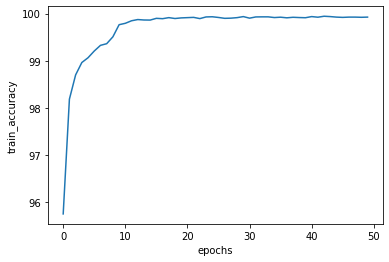

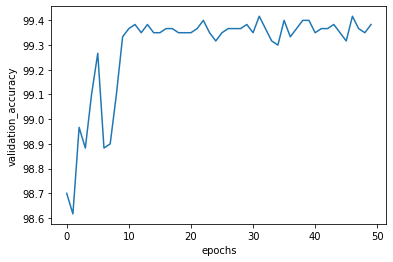

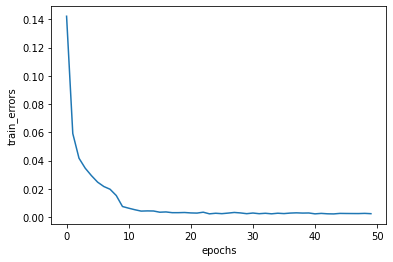

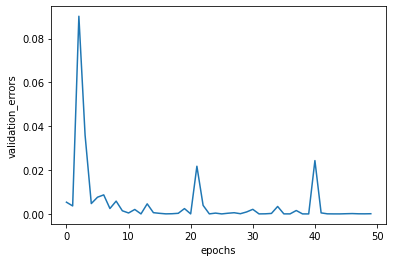

In [16]:
#Train the CNN
tr_avgLoss_list = []
tr_accuracy_list =[]
dev_avgLoss_list = []
dev_accuracy_list = []

#loop over epochs
for epoch in range(hyperparam.num_epochs):
    tr_num_correct = 0
    tr_num_samples = 0
    tr_total_loss = 0.0
    dev_num_correct = 0
    dev_num_samples = 0
    dev_total_loss = 0.0
    
    #Training
    cnn_model.train(True) 
    scheduler.step()  #to decrease the lr by 10% every 10 epochs because as you move towards the minima the steps size needs to decrease so it doesnt jump over the minima
    with torch.set_grad_enabled(True):
        for local_batch, local_labels in train_loader:
            local_batch=local_batch.unsqueeze(1)
            
            if torch.cuda.is_available():
              local_batch = local_batch.cuda()
              local_labels = local_labels.cuda()
            
            optimizer.zero_grad()
            
            
            local_batch = local_batch.float()
            local_labels = local_labels.float()
            #local_batch, local_labels = Variable(local_batch), Variable(local_labels)
            
            #Model computations
            out1 = cnn_model(local_batch)
            
            #Cross Entropy loss calculation
            ploss = criterion(out1, local_labels.long())
            tr_total_loss += ploss*hyperparam.bs
            
            #Backpropogation
            ploss.backward() #gradient calculation
            optimizer.step() #weight update
           
            
            sel_class = torch.argmax(out1, dim=1) #chooses the maximum value of the softmax layer
            
            tr_num_correct += sel_class.eq(local_labels).sum().item()
            tr_num_samples += hyperparam.bs
        
        tr_avgLoss = tr_total_loss/len(train_loader.dataset)
        tr_avgLoss_list.append(tr_avgLoss)
        
        tr_accuracy = tr_num_correct*100/tr_num_samples 
        tr_accuracy_list.append(tr_accuracy)

    #validation 
    with torch.set_grad_enabled(False):
      cnn_model.eval()

      for local_batch,local_labels in dev_loader:
        local_batch=local_batch.unsqueeze(1)

        local_batch=local_batch.float()
        local_labels=local_labels.float()
        #local_batch,local_labels=Variable(local_batch),Variable(local_labels)
        
        if torch.cuda.is_available():
            local_batch = local_batch.cuda()
            local_labels = local_labels.cuda()
        #Model computations2
        out1=cnn_model(local_batch)

        #CrossEntropy loss calculation
        pLoss=criterion(out1,local_labels.long())
        dev_total_loss +=ploss*hyperparam.bs
        sel_class=torch.argmax(out1,dim=1)

        dev_num_correct+=sel_class.eq(local_labels).sum().item()

        #print(correction)
        dev_num_samples+=hyperparam.bs

      dev_avgLoss=dev_total_loss/len(dev_loader.dataset)
      dev_avgLoss_list.append(dev_avgLoss)

      dev_accuracy=dev_num_correct*100/dev_num_samples
      dev_accuracy_list.append(dev_accuracy)
    print("accuracy",tr_accuracy,dev_accuracy)

plt.plot(np.arange(0,hyperparam.num_epochs,1),tr_accuracy_list)
plt.xlabel("epochs")
plt.ylabel("train_accuracy")
plt.show()

plt.plot(np.arange(0,hyperparam.num_epochs,1),dev_accuracy_list)
plt.xlabel("epochs")
plt.ylabel("validation_accuracy")
plt.show()

plt.plot(np.arange(0,hyperparam.num_epochs,1),tr_avgLoss_list)
plt.xlabel("epochs")
plt.ylabel("train_errors")
plt.show()

plt.plot(np.arange(0,hyperparam.num_epochs,1),dev_avgLoss_list)
plt.xlabel("epochs")
plt.ylabel("validation_errors")
plt.show()

### From the above diagram we can say that the model reasonably fits the validation data set as the curves of training and validation are similar expect for the variations in the valiation set which is acceptable. 

In [17]:
def make_predictions(data_loader):
    cnn_model.eval()
    test_preds = torch.LongTensor()
    
    for i, data in enumerate(data_loader):
        data = data.unsqueeze(1) #adds a dimension of the length 1
        
        if torch.cuda.is_available():
            data = data.cuda()
            
        output = cnn_model(data.float()) #convert to float here as well
        
        preds = output.cpu().data.max(1, keepdim=True)[1]
        test_preds = torch.cat((test_preds, preds), dim=0)
        
    return test_preds

In [18]:
test_set_preds = make_predictions(test_loader)
test_set_preds

tensor([[7],
        [2],
        [1],
        ...,
        [4],
        [5],
        [6]])

In [19]:
submission_df=pd.DataFrame()
submission_df["label"]=test_set_preds.numpy().squeeze()
submission_df.head()

,label
0,7
1,2
2,1
3,0
4,4


### Confusion Matrix of testing set
### Accuracy of the testing set

In [20]:
from sklearn.metrics import confusion_matrix

y_true = mnist["target"][60000:].astype(int)
y_pred = np.array(submission_df["label"])
cf = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true,y_pred)
print("Accuracy of the test set is:",acc*100,"%")
print("Confusion matrix for the test set: \n",cf)

Accuracy of the test set is: 99.44 %
Confusion matrix for the test set: 
 [[ 978    1    0    0    0    0    0    1    0    0]
 [   0 1135    0    0    0    0    0    0    0    0]
 [   1    0 1027    0    0    0    0    4    0    0]
 [   0    0    1 1006    0    2    0    0    1    0]
 [   0    0    0    0  978    0    0    0    0    4]
 [   0    0    0    7    0  883    1    0    0    1]
 [   2    1    0    0    3    1  949    0    2    0]
 [   0    4    3    0    0    0    0 1020    0    1]
 [   0    0    1    0    0    0    0    0  972    1]
 [   0    0    1    0    5    1    0    3    3  996]]


#### Thus, the accuracy of the baseline system is almost 99 which suggests that the model is performing well. The confusion matrix also gives good results as the count around the diagonal is high which is ideal.

#### Using the batchnormalization we are getting very good accuracy for train, test and dev set